In [1]:
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
import plotnine as p9

In [41]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 5, 4, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [0, 0, 0, 1, 1],
})

sample_df

,subject,time,event,x
0,A,1,1,0
1,B,3,1,0
2,C,5,1,0
3,D,4,1,1
4,E,6,0,1


In [36]:
hospital_df = pd.DataFrame({
    'subject': range(12),
    'time': [60, 32, 60, 60, 60, 4, 18, 60, 9, 31, 53, 17],
    'event': [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1],
    'x': np.concatenate(([0] * 5, [1] * 7))
})

hospital_df

,subject,time,event,x
0,0,60,0,0
1,1,32,1,0
2,2,60,0,0
3,3,60,0,0
4,4,60,0,0
5,5,4,1,1
6,6,18,1,1
7,7,60,0,1
8,8,9,1,1
9,9,31,1,1


We can run the Cox Proportional Hazard model using `CoxPHFitter()`:

In [42]:
cph = CoxPHFitter()
cph.fit(sample_df, duration_col='time', event_col='event', formula='x')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -4.17
         time fit was run = 2023-05-29 18:11:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -1.21       0.30       1.17            -3.51             1.09                 0.03                 2.98

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.03 0.30       1.72
---
Concordance = 0.70
Partial AIC = 10.35
log-likelihood ratio test = 1.23 on 1 df
-log2(p) of ll-ratio test = 1.90

Sample data:

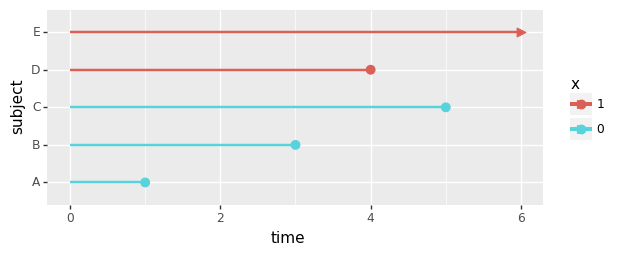

<ggplot: (8755740994618)>

In [46]:
def plot_eventtimes_per_subject(df):
    return (
        p9.ggplot(
            df, p9.aes(x='time', y='subject', color='factor(x)')
        )
        + p9.geom_segment(
            p9.aes(x=0, xend='time', yend='subject'), size=1
        )
        + p9.geom_point(data=df[df['event'] == 1], shape='o', size=3)
        + p9.geom_point(data=df[df['event'] == 0], shape='>', size=3)
        + p9.xlim(0, None)
        + p9.scale_color_discrete(name='x')
        + p9.coord_fixed(0.5)
    )

plot_eventtimes_per_subject(sample_df)

In [47]:
def relative_hazard(beta, x):
    return np.exp(beta * x)

In [65]:
tmp = sample_df[(sample_df['subject'] == 'B') & (sample_df['event'] == 1)]
tmp['time'].iloc[0]

3

In [108]:
sample_df['subject']

0    A
1    B
2    C
3    D
4    E
Name: subject, dtype: object

In [124]:
def log_likelihood(df, subject, beta):
    subject_df = df[(df['subject'] == subject) & (df['event'] == 1)]
    if len(subject_df) == 0: # check if subject is censored
        return(0)
    event_time = subject_df['time'].iloc[0]
    at_risk_df = df[df['time'] >= event_time]
    subject_log_hazard = beta * subject_df['x'].iloc[0]
    total_at_risk_hazards = np.exp(beta * at_risk_df['x']).sum()
    return(subject_log_hazard - np.log(total_at_risk_hazards))


In [129]:
def total_log_likelihood(df, beta):
    subjects = df['subject'].unique()
    sum_log_likelihood = 0
    for subject in subjects:
        sum_log_likelihood += log_likelihood(df, subject, beta)
    return(sum_log_likelihood)

In [141]:
def total_loglik_vs_beta(df, betas=np.arange(-5, 5, 0.1)):
    total_log_likelihoods = [total_log_likelihood(df, beta) for beta in betas]
    return(
        pd.DataFrame({
            'beta': betas,
            'total_log_lik': total_log_likelihoods
        })
    )

In [143]:
fit_df = total_loglik_vs_beta(sample_df)

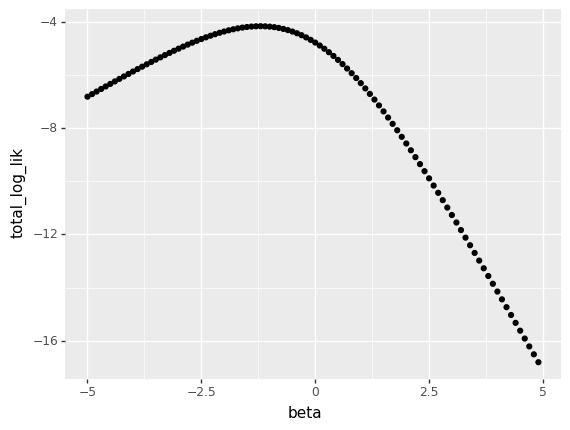

<ggplot: (8755739454055)>

In [145]:
(
    p9.ggplot(fit_df, p9.aes('beta', 'total_log_lik'))
    + p9.geom_point()
)

In [139]:
np.range(-5, 5, 0.1)

AttributeError: module 'numpy' has no attribute 'range'

In [140]:
np.arange(-5, 5, 0.1)

array([-5.00000000e+00, -4.90000000e+00, -4.80000000e+00, -4.70000000e+00,
       -4.60000000e+00, -4.50000000e+00, -4.40000000e+00, -4.30000000e+00,
       -4.20000000e+00, -4.10000000e+00, -4.00000000e+00, -3.90000000e+00,
       -3.80000000e+00, -3.70000000e+00, -3.60000000e+00, -3.50000000e+00,
       -3.40000000e+00, -3.30000000e+00, -3.20000000e+00, -3.10000000e+00,
       -3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00,
       -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
       -2.20000000e+00, -2.10000000e+00, -2.00000000e+00, -1.90000000e+00,
       -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00,
       -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
       -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -1.77635684e-14,  1.00000000e-01,
        2.00000000e-01,  